In [1]:
from __future__ import division
import numpy as np
from sys import stdout
from sklearn.metrics import pairwise_kernels


def MMD2u(K, m, n):
    """The MMD^2_u unbiased statistic.
    """
    Kx = K[:m, :m]
    Ky = K[m:, m:]
    Kxy = K[:m, m:]
    return 1.0 / (m * (m - 1.0)) * (Kx.sum() - Kx.diagonal().sum()) + \
        1.0 / (n * (n - 1.0)) * (Ky.sum() - Ky.diagonal().sum()) - \
        2.0 / (m * n) * Kxy.sum()


def compute_null_distribution(K, m, n, iterations=10000, verbose=False,
                              random_state=None, marker_interval=1000):
    """Compute the bootstrap null-distribution of MMD2u.
    """
    if type(random_state) == type(np.random.RandomState()):
        rng = random_state
    else:
        rng = np.random.RandomState(random_state)

    mmd2u_null = np.zeros(iterations)
    for i in range(iterations):
        if verbose and (i % marker_interval) == 0:
            print(i),
            stdout.flush()
        idx = rng.permutation(m+n)
        K_i = K[idx, idx[:, None]]
        mmd2u_null[i] = MMD2u(K_i, m, n)

    if verbose:
        print("")

    return mmd2u_null


def compute_null_distribution_given_permutations(K, m, n, permutation,
                                                 iterations=None):
    """Compute the bootstrap null-distribution of MMD2u given
    predefined permutations.

    Note:: verbosity is removed to improve speed.
    """
    if iterations is None:
        iterations = len(permutation)

    mmd2u_null = np.zeros(iterations)
    for i in range(iterations):
        idx = permutation[i]
        K_i = K[idx, idx[:, None]]
        mmd2u_null[i] = MMD2u(K_i, m, n)

    return mmd2u_null


def kernel_two_sample_test(X, Y, kernel_function='rbf', iterations=10000,
                           verbose=False, random_state=None, **kwargs):
    """Compute MMD^2_u, its null distribution and the p-value of the
    kernel two-sample test.

    Note that extra parameters captured by **kwargs will be passed to
    pairwise_kernels() as kernel parameters. E.g. if
    kernel_two_sample_test(..., kernel_function='rbf', gamma=0.1),
    then this will result in getting the kernel through
    kernel_function(metric='rbf', gamma=0.1).
    """
    m = len(X)
    n = len(Y)
    XY = np.vstack([X, Y])
    K = pairwise_kernels(XY, metric=kernel_function, **kwargs)
    mmd2u = MMD2u(K, m, n)
    if verbose:
        print("MMD^2_u = %s" % mmd2u)
        print("Computing the null distribution.")

    mmd2u_null = compute_null_distribution(K, m, n, iterations,
                                           verbose=verbose,
                                           random_state=random_state)
    p_value = max(1.0/iterations, (mmd2u_null > mmd2u).sum() /
                  float(iterations))
    if verbose:
        print("p-value ~= %s \t (resolution : %s)" % (p_value, 1.0/iterations))

    return mmd2u, mmd2u_null, p_value




MMD^2_u = 0.03862081638998227
Computing the null distribution.
0
1000
2000
3000
4000
5000
6000
7000
8000
9000

p-value ~= 0.1087 	 (resolution : 0.0001)


/home/ak/Envs/resrPyth3/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


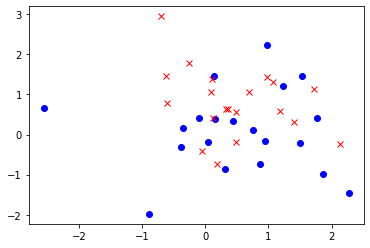

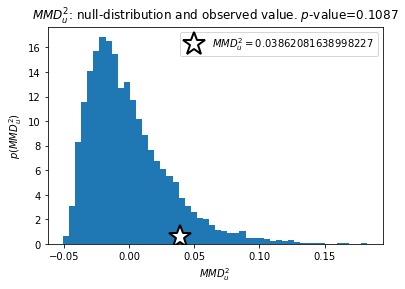

In [4]:
# if __name__ == '__main__':

import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

np.random.seed(0)

m = 20
n = 20
d = 2

sigma2X = np.eye(d)
muX = np.zeros(d)

sigma2Y = np.eye(d)
muY = np.ones(d)
# muY = np.zeros(d)

iterations = 10000

X = np.random.multivariate_normal(mean=muX, cov=sigma2X, size=m)
Y = np.random.multivariate_normal(mean=muY, cov=sigma2Y, size=n)

if d == 2:
    plt.figure()
    plt.plot(X[:, 0], X[:, 1], 'bo')
    plt.plot(Y[:, 0], Y[:, 1], 'rx')

sigma2 = np.median(pairwise_distances(X, Y, metric='euclidean'))**2
mmd2u, mmd2u_null, p_value = kernel_two_sample_test(X, Y,
                                                    kernel_function='rbf',
                                                    gamma=1.0/sigma2,
                                                    verbose=True)
# mmd2u, mmd2u_null, p_value = kernel_two_sample_test(X, Y,
#                                                     kernel_function='linear',
#                                                     verbose=True)

plt.figure()
prob, bins, patches = plt.hist(mmd2u_null, bins=50, normed=True)
plt.plot(mmd2u, prob.max()/30, 'w*', markersize=24, markeredgecolor='k',
         markeredgewidth=2, label="$MMD^2_u = %s$" % mmd2u)
plt.xlabel('$MMD^2_u$')
plt.ylabel('$p(MMD^2_u)$')
plt.legend(numpoints=1)
plt.title('$MMD^2_u$: null-distribution and observed value. $p$-value=%s'
          % p_value)
plt.show()
